<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/13_poetry_model_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Lorca Poem creator from scratch

In [11]:
!pip install tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32893 sha256=0463e6d29cf558be10b4f8764f79b86ee5e0c312e0416d476bcd9836ce01c5f8
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika


In [13]:
from tika import parser # pip install tika

raw = parser.from_file('/content/gdrive/MyDrive/lorca/libro_de_poemas.pdf')
print(raw['content'])
















































 

LIBRO DE 

POEMAS 
 

 

Federico García Lorca 

 
 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 
 



A mi hermano 
Paquito 

 
 
 

POÉTICA 
 

   (De viva voz a G[erardo] D[iego].) 
 
Pero, ¿qué voy a decir yo de la Poesía? ¿Qué voy a decir de esas nubes, de 

ese cielo? Mirar, mirar, mirarlas, mirarle y nada más. Comprenderás que un 
poeta no puede decir nada de la Poesía. Eso déjaselo a los críticos y 
profesores. Pero ni tú ni yo ni ningún poeta sabemos lo que es la Poesía. 

Aquí está: mira. Yo tengo el fuego en mis manos. Yo lo entiendo y trabajo 
con él perfectamente, pero no puedo hablar de él sin literatura. Yo 
comprendo todas las poéticas; podría hablar de ellas si no cambiara de 
opinión cada cinco minutos. No sé. Puede que algún día me guste la poesía 
mala muchísimo, como me gusta (nos gusta) hoy la música mala con locura. 
Quemaré el Partenón por la noche para empezar a levantarlo por la ma

In [14]:
from fastai.text.all import *

In [184]:
txt = raw['content']; txt[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\nLIBRO DE \n\nPOEMAS \n \n\n \n\nFederico García Lorca \n\n \n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n \n\n\n\nA mi hermano \nPaquito \n\n \n \n \n\nPOÉTICA \n \n\n   (De viva voz a G[erardo] D[iego].) \n \nPero, ¿qué voy a decir yo de la Poesía? ¿Qué voy a decir de esas nubes, de \n\nese cielo? Mirar, mirar, mirarlas, mirarle y nada más. Comprenderás que un \npoeta no puede decir nada de la Poesía. Eso déjaselo a los críticos y \nprofesores. Pero ni tú ni yo ni ningún poeta sabemos lo que es la Poesía. \n\nAquí está: mira. Yo tengo el fuego en mis manos. Yo lo entiendo y trabajo \ncon él perfectamente, pero no puedo hablar de él sin literatura. Yo \ncomprendo todas las poéticas; podría hablar de ellas si no cambiara de \nopinión cada cinco minutos. No sé. Puede que algún día me guste la poesía \nmala 

In [186]:
#tokens = txt.replace('\n',"")
tokens = txt.replace('[',"")
tokens = tokens.replace(']',"")
tokens = tokens.replace('(',"")
tokens = tokens.replace(')',"")
tokens = tokens.replace('.'," .")
tokens = tokens.replace(';'," ;")
tokens = tokens.replace(','," ,")
tokens[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\nLIBRO DE \n\nPOEMAS \n \n\n \n\nFederico García Lorca \n\n \n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n \n\n\n\nA mi hermano \nPaquito \n\n \n \n \n\nPOÉTICA \n \n\n   De viva voz a Gerardo Diego . \n \nPero , ¿qué voy a decir yo de la Poesía? ¿Qué voy a decir de esas nubes , de \n\nese cielo? Mirar , mirar , mirarlas , mirarle y nada más . Comprenderás que un \npoeta no puede decir nada de la Poesía . Eso déjaselo a los críticos y \nprofesores . Pero ni tú ni yo ni ningún poeta sabemos lo que es la Poesía . \n\nAquí está: mira . Yo tengo el fuego en mis manos . Yo lo entiendo y trabajo \ncon él perfectamente , pero no puedo hablar de él sin literatura . Yo \ncomprendo todas las poéticas ; podría hablar de ellas si no cambiara de \nopinión cada cinco minutos . No sé . Puede que algún día me guste la poe

In [187]:
tokens = tokens.split()

In [188]:
vocab = L(*tokens).unique()
vocab


(#4151) ['LIBRO','DE','POEMAS','Federico','García','Lorca','A','mi','hermano','Paquito'...]

In [189]:
seql = 40

In [190]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#16689) [0,1,2,3,4,5,6,7,8,9...]

In [191]:
seqs = L((tensor(nums[i:i+seql]), nums[i+seql]) for i in range(0,len(nums)-seql-1,seql))
seqs

(#417) [(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 14, 22, 23, 24, 25, 26, 27, 21, 14, 22, 24, 28, 29, 19, 24, 30, 31, 32]), 19),(tensor([19, 33, 19, 34, 19, 35, 36, 37, 38, 17, 39, 40, 41, 42, 43, 44, 22, 37, 24, 25, 45, 17, 46, 47, 14, 48, 49, 36, 50, 17, 18, 51, 52, 51, 23, 51, 53, 42, 54, 55]), 40),(tensor([40, 56, 25, 45, 17, 57, 58, 59, 17, 60, 61, 62, 63, 64, 65, 66, 17, 60, 55, 67, 36, 68, 69, 70, 71, 19, 72, 43, 73, 74, 24, 70, 75, 76, 17, 60, 77, 78, 79, 80]), 81),(tensor([ 81,  82,  74,  24,  83,  84,  43,  85,  24,  86,  87,  88,  89,  17,  90,  91,  17,  92,  40,  93,  94,  95,  96,  25,  97,  98,  99,  19, 100,  95, 101, 102, 101, 103,  25, 104,  98,  69,
        105,  17]), 106),(tensor([106,  62, 107, 108,  25, 109, 110, 111,  14, 112, 108,  25, 113,  36,  43, 114, 115,  17, 116,  65, 117, 118, 119,  14, 120,  24,  25,  45,  19,  72,  24,  55, 121,  40,  43,  73,  74,  56,
         24,   7]), 97),(tensor([ 97,  17, 1

In [192]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

In [75]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(seql):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [79]:
learn = Learner(dls, LMModel2(len(vocab), 32), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.401573,8.359144,0.000000,00:00
1,8.297399,8.222700,0.000000,00:00
2,7.958394,30.237970,0.035714,00:00
3,8.121090,7.689475,0.035714,00:00
4,7.637074,7.614786,0.047619,00:00
5,7.235262,7.512228,0.047619,00:00
6,6.864734,7.440926,0.047619,00:00
7,6.522115,7.421534,0.047619,00:00
8,6.219722,7.430132,0.047619,00:00
9,5.967547,7.433140,0.047619,00:00


In [85]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(seql):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [81]:
m = len(seqs)//bs
m,bs,len(seqs)

(6, 64, 417)

In [82]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [83]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [84]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.349112,8.313526,0.000000,00:00
1,8.295486,8.237252,0.000000,00:00
2,8.167057,8.065930,0.015625,00:00
3,7.870379,8.509933,0.031250,00:00
4,7.218310,8.209124,0.062500,00:00
5,6.662850,7.678238,0.093750,00:00
6,6.208212,8.232747,0.078125,00:00
7,5.832365,8.113040,0.093750,00:00
8,5.527820,8.496554,0.093750,00:00
9,5.280161,8.605272,0.093750,00:00


In [142]:
sl = 40
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [87]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

In [88]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [90]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.334532,8.298872,0.000391,00:01
1,8.254466,8.053873,0.014453,00:01
2,14.621455,7.088810,0.035937,00:01
3,12.384159,7.435526,0.040234,00:01
4,11.029077,7.086061,0.029297,00:01
5,10.028005,6.987484,0.060938,00:01
6,9.261831,6.944528,0.063672,00:01
7,8.656482,6.945956,0.069141,00:01
8,8.163579,6.919015,0.071484,00:01
9,7.756437,6.956716,0.070312,00:01


In [91]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [92]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.346545,8.337866,0.000391,00:01
1,8.328381,8.286561,0.000391,00:01
2,8.271790,8.035854,0.049219,00:01
3,8.080894,7.346517,0.064453,00:01
4,7.779276,6.876366,0.050781,00:01
5,7.493887,6.804914,0.051562,00:01
6,7.278198,6.879838,0.054297,00:01
7,7.117814,6.931529,0.050000,00:01
8,6.991854,6.957365,0.050000,00:01
9,6.890099,6.977496,0.049219,00:01


In [93]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [94]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.342263,8.332246,0.001563,00:01
1,8.318126,8.207052,0.016016,00:01
2,8.074806,7.034512,0.017188,00:01
3,7.637185,7.098006,0.052734,00:01
4,7.352601,7.232337,0.053516,00:01
5,7.147218,7.363180,0.048828,00:01
6,6.996726,7.406292,0.050781,00:01
7,6.882939,7.430689,0.053125,00:01
8,6.793693,7.451829,0.048047,00:01
9,6.722270,7.464892,0.048828,00:01


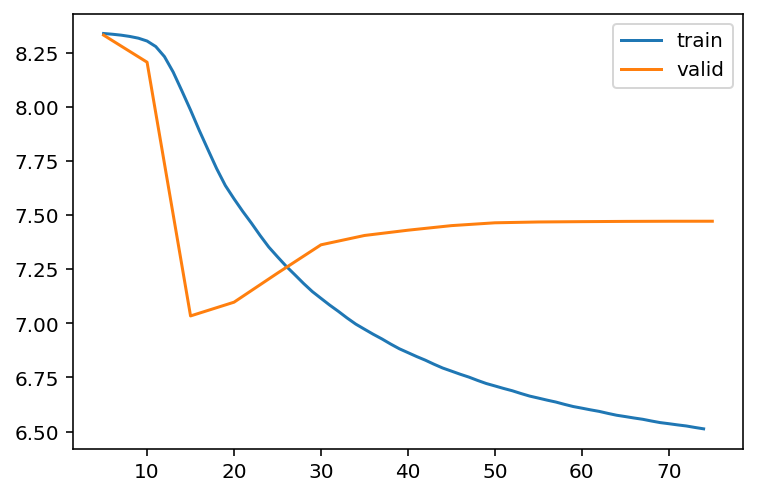

In [95]:
learn.recorder.plot_loss()

In [96]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

In [97]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [146]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [145]:
learn.fit_one_cycle(25, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

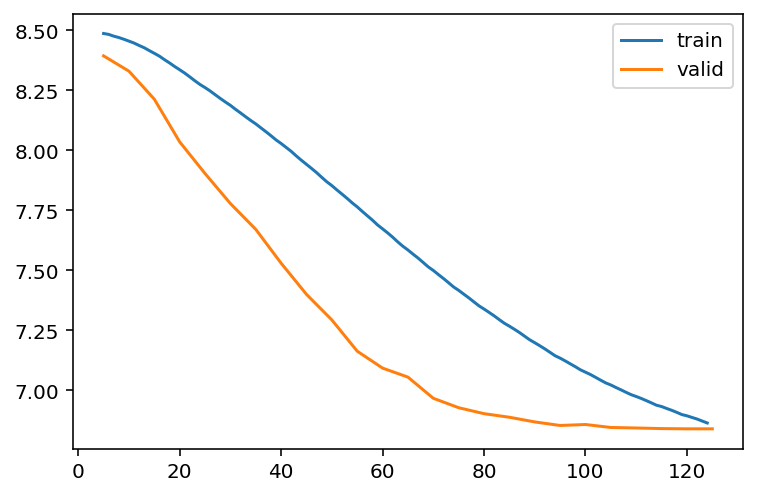

In [135]:
learn.recorder.plot_loss()

In [194]:
df = pd.DataFrame({'col':tokens})

In [206]:
df = pd.DataFrame([sub.split(";") for sub in [' '.join(tokens)]])

In [211]:
df = df.transpose()


,0
0,"LIBRO DE POEMAS Federico García Lorca A mi hermano Paquito POÉTICA De viva voz a Gerardo Diego . Pero , ¿qué voy a decir yo de la Poesía? ¿Qué voy a decir de esas nubes , de ese cielo? Mirar , mirar , mirarlas , mirarle y nada más . Comprenderás que un poeta no puede decir nada de la Poesía . Eso déjaselo a los críticos y profesores . Pero ni tú ni yo ni ningún poeta sabemos lo que es la Poesía . Aquí está: mira . Yo tengo el fuego en mis manos . Yo lo entiendo y trabajo con él perfectamente , pero no puedo hablar de él sin literatura . Yo comprendo todas las poéticas"
1,"podría hablar de ellas si no cambiara de opinión cada cinco minutos . No sé . Puede que algún día me guste la poesía mala muchísimo , como me gusta nos gusta hoy la música mala con locura . Quemaré el Partenón por la noche para empezar a levantarlo por la mañana y no terminarlo nunca . En mis conferencias he hablado a veces de la Poesía , pero de lo único que no puedo hablar es de mi poesía . Y no porque sea un inconsciente de lo que hago . Al contrario , si es verdad que soy poeta por la gracia de Dios -o del demonio- , también lo es que lo soy por la gracia de la técnica y del esfuerzo ..."
2,"gira , corazón . Aire del Norte , ¡oso blanco del viento! llegas sobre mi carne tembloroso de auroras boreales , con tu capa de espectros capitanes , y riyéndote a gritos del Dante , ¡oh pulidor de estrellas! pero vienes demasiado tarde . Mi almario está musgoso y he perdido la llave . Sin ningún viento , ¡hazme caso! gira , corazón"
3,"gira , corazón . Brisas , gnomos y vientos de ninguna parte . Mosquitos de la rosa de pétalos pirámides . Alisios destetados entre los rudos árboles , flautas en la tormenta , ¡dejadme! tiene recias cadenas mi recuerdo , y está cautiva el ave que dibuja con trinos la tarde . Las cosas que se van no vuelven nunca todo el mundo lo sabe , y entre el claro gentío de los vientos es inútil quejarse . , ¿Verdad , chopo , maestro de la brisa? ¡es inútil quejarse! Sin ningún viento , ¡hazme caso! gira , corazón"
4,"gira , corazón . LOS ENCUENTROS DE UN CARACOL AVENTURERO A Ramón P . Roda . Hay dulzura infantil en la mañana quieta . Los árboles extienden sus brazos a la tierra . Un vaho tembloroso cubre las sementeras , y las arañas tienden sus caminos de seda -rayas al cristal limpio del aire .- En la alameda un manantial recita su canto entre las hierbas . Y el caracol , pacífico burgués de la vereda , ignorado y humilde , el paisáje contempla . . La divina quietud de la Naturaleza le dio valor y fe , y olvidando las penas de su hogar , deseó ver el fin de la senda . Echó a andar a internóse en un ..."
5,"cuatro uñas de gato , Pasé por el jardín de Cartagena la verbena invocando y perdí la sortija de mi dicha al pasar el arroyo imaginario . Fui también caballero una tarde fresquita de mayo . Ella era entonces para mí el enigma , Estrella azul sobre mi pecho intacto . Cabalgué lentamente hacia los cielos , era un domingo de pipirigallo , y vi que en vez de rosas y claveles ellá tronchaba lirios con sus manos . Yo siempre fui intranquilo , niños buenos del prado , el ella del romance me sumía en ensoñares claros: ¿Quién será la que coge los claveles y las rosas de mayo? ¿Y por qué la verán s..."
6,"tus senos resbalan escanciando aromas y empieza a curvarse tu espléndida espalda . ¡Oh mujer esbelta , maternal y ardiente! Virgen dolorosa que tiene clavadas todas las estrellas del cielo profundo en su corazón ya sin esperanza . Eres el espejo de una Andalucía que sufre pasiones gigantes y calla , pasiones mecidas por los abanicos y por las mantillas sobre las gargantas que tienen temblores de sangre , de nieve y arañazos rojos hechos por miradas . Te vas por la niebla del otoño , virgen como Inés , Cecilia , y la dulce Clara , siendo una bacante que hubiera danzado de pámpanos verdes y..."
7,"es el maestro un chopo antiguo que mueve tranquilo sus brazos muertos . Ahora en el monte lejano jugarán todos los muertos a la baraja . ¡Es tan triste 

In [223]:
df['text2'] = 0

In [225]:
df.columns = ['text', 'textfalse']

In [241]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),get_x=ColReader('text'),splitter=RandomSplitter(0.2))

dls_lm = dls_lm.dataloaders(df, bs=40)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos sois de los prados de xxmaj xxunk , llenos con sangre de lo inmortal . ¡ xxunk xxunk ! xxmaj sois xxunk de viejos xxunk perdidos ya . xxmaj xxunk xxunk lujuria virgen como no tuvo otro xxunk . ¡ xxunk del xxmaj mediodía ! xxmaj xxunk en xxunk para xxunk que desde el fondo de las campiñas el xxunk os dice : ¡ xxunk ! , al pasar . xxup","sois de los prados de xxmaj xxunk , llenos con sangre de lo inmortal . ¡ xxunk xxunk ! xxmaj sois xxunk de viejos xxunk perdidos ya . xxmaj xxunk xxunk lujuria virgen como no tuvo otro xxunk . ¡ xxunk del xxmaj mediodía ! xxmaj xxunk en xxunk para xxunk que desde el fondo de las campiñas el xxunk os dice : ¡ xxunk ! , al pasar . xxup fin"
1,"sereno , xxunk xxbos xxunk su xxunk con mi vida muerta . ¡ dime en qué remanso xxunk xxunk como se xxunk las pasiones viejas ! ¡ conozco el misterio que cantas , xxunk xxbos xxup libro xxup de xxup xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk a mi hermano xxmaj xxunk xxup xxunk xxmaj de xxunk voz a xxmaj xxunk xxmaj xxunk . xxmaj pero , ¿ qué voy a decir",", xxunk xxbos xxunk su xxunk con mi vida muerta . ¡ dime en qué remanso xxunk xxunk como se xxunk las pasiones viejas ! ¡ conozco el misterio que cantas , xxunk xxbos xxup libro xxup de xxup xxunk xxmaj xxunk xxmaj xxunk xxmaj xxunk a mi hermano xxmaj xxunk xxup xxunk xxmaj de xxunk voz a xxmaj xxunk xxmaj xxunk . xxmaj pero , ¿ qué voy a decir yo"


In [242]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [243]:
learn.fit_one_cycle(100,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,6.076960,6.426732,0.175000,618.150574,00:00
1,6.070642,6.411767,0.175000,608.968811,00:00
2,6.039774,6.392125,0.175000,597.124207,00:00
3,6.021873,6.366403,0.175658,581.960815,00:00
4,6.003663,6.331668,0.176316,562.093567,00:00
5,5.988152,6.287087,0.176974,537.585327,00:00
6,5.969967,6.232810,0.176974,509.184540,00:00
7,5.938139,6.170389,0.178289,478.372223,00:00
8,5.902138,6.098325,0.178947,445.111694,00:00
9,5.865912,6.018363,0.177632,410.905182,00:00


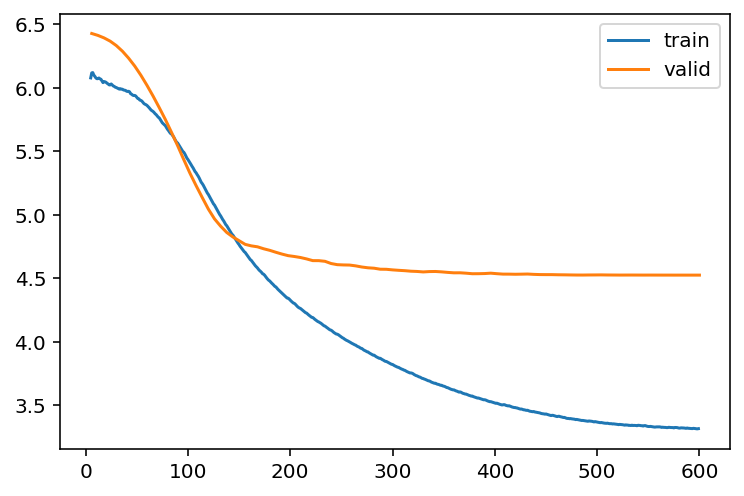

In [244]:
learn.recorder.plot_loss()

In [247]:
TEXT = 'Un vaho tembloroso cubre las sementeras, y las arañas tienden sus caminos de seda.' 
N_WORDS = 40
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds

['Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Copa del prado , UN UN IBA niña de ideas , Yo , de la fuente , La los astros y el agua del agua , y una aurora de estrellas . Las',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . La canción del prado , entre la fuente . Las paz de un fin de las estrellas , en la luna de oro , ¿ qué muy lejos , y un mío en la flores ? Yo',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . En la pradera el ondas que los brazos de los mares ? En la tierra es un sabe . Las naturaleza como la casi del misterio . TÚ , no dejo la fuente de mi eterno']

In [246]:
preds

['Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un OTOÑO en la gran sombra de la vientos . La Muerte Satán el alma del árbol . Doña Muerte , La Muerte Un Campo De Cristo',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . CANCION DIJO Rojo Un un viejo claras de la luz , y un ciencia de los silencio . Las estrellas y un campo de plata marchita . Un fondo de niebla de horas con',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un aire en un amor y la luna que el que una mañana por la fuente del bosque de los años cadencia , y los niños y y los campos y inmortal ! Los árboles donde los mares']